In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)

In [4]:


# Importing data
df = pd.read_csv("Leads.csv")
df.head(2)


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [6]:
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


## 
Data Cleaning¶


In [7]:


# Standardising column names
df.columns = ['_'.join(name.lower().split()[:3]) for name in df.columns]

#standardising categorical values
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower().str.replace(' ', '_').str.strip())

# Taking a look at all unique values for every column to check for abnormalities/inconsistencies
for col in df.columns[2:]:
    print(col.upper(), end=': ')
    print(df[col].unique())
    print()



LEAD_ORIGIN: ['api' 'landing_page_submission' 'lead_add_form' 'lead_import'
 'quick_add_form']

LEAD_SOURCE: ['olark_chat' 'organic_search' 'direct_traffic' 'google' 'referral_sites'
 'welingak_website' 'reference' 'facebook' nan 'blog' 'pay_per_click_ads'
 'bing' 'social_media' 'welearn' 'click2call' 'live_chat'
 'welearnblog_home' 'youtubechannel' 'testone' 'press_release' 'nc_edm']

DO_NOT_EMAIL: ['no' 'yes']

DO_NOT_CALL: ['no' 'yes']

CONVERTED: [0 1]

TOTALVISITS: [  0.   5.   2.   1.   4.   8.  11.   6.   3.   7.  13.  17.  nan   9.
  12.  10.  16.  14.  21.  15.  22.  19.  18.  20.  43.  30.  23.  55.
 141.  25.  27.  29.  24.  28.  26.  74.  41.  54. 115. 251.  32.  42.]

TOTAL_TIME_SPENT: [   0  674 1532 ...  603  483  927]

PAGE_VIEWS_PER: [ 0.    2.5   2.    1.    4.    8.    2.67 11.    5.    6.    3.    1.33
  1.5   3.5   7.    2.33 13.    8.5   5.5   1.67   nan  4.5   3.33 16.
 12.    1.71  1.8   6.5   4.33 14.    3.4  10.    1.25  1.75  2.63 15.
  2.25  3.67  1.43  9.  

In [8]:
# removing redundant columns
df.drop(['prospect_id', 'lead_number', 'receive_more_updates', 'update_me_on', 'get_updates_on', 'i_agree_to', 'last_activity'], axis=1, inplace=True)

# Replacing all 'select' values with NaN
df = df.replace('select', np.nan)

# replacing "wrong number given" with "invalid number"
df.tags = df.tags.replace("wrong_number_given", "invalid_number")

# Cleaning "lead_source column"
value_counts = df.lead_source.value_counts()

# Values with frequency less than 30 are classified under "others"
df.lead_source = df.lead_source.replace(value_counts[value_counts < 30].index, "others")

# Cleaning "country"
value_counts = df.country.value_counts()

# We will categorise Country in binary as 'India' and 'Other' 
df.country = df.country.replace(df.country[df.country != 'india'].dropna().unique(), "others")


#Dealing with NaN values¶


In [9]:


# Percentage of NA values in every column
round(df.isna().sum().sort_values(ascending=False)/len(df)*100, 2)



how_did_you                    78.46
lead_profile                   74.19
lead_quality                   51.59
asymmetrique_profile_score     45.65
asymmetrique_activity_score    45.65
asymmetrique_profile_index     45.65
asymmetrique_activity_index    45.65
city                           39.71
specialization                 36.58
tags                           36.29
what_matters_most              29.32
what_is_your                   29.11
country                        26.63
page_views_per                  1.48
totalvisits                     1.48
lead_source                     0.39
through_recommendations         0.00
a_free_copy                     0.00
lead_origin                     0.00
newspaper_article               0.00
digital_advertisement           0.00
newspaper                       0.00
x_education_forums              0.00
magazine                        0.00
search                          0.00
total_time_spent                0.00
converted                       0.00
d

In [10]:
# Column "how_did_you" has too many NA values that can not be imputed. It is better to drop the column. 
df.drop('how_did_you', axis=1, inplace=True)

# Column "lead_profile" has too many NA values that can not be imputed.
print(df.lead_profile.value_counts())

print("\n\nWe could convert the column to binary by defining whether it is a 'potential_lead' or not.")
print(f"\nIf made binary variable:\nis_potential_lead: {df.lead_profile.value_counts()[0]}\nis_not_lead: {len(df) - df.lead_profile.value_counts()[0]}\n")
print("But given the high frequency of NA values, There is a lot of uncertainty whether those values are leads or not. This forces us to drop the column altogether.")

df.drop('lead_profile', axis=1, inplace=True)

lead_profile
potential_lead                 1613
other_leads                     487
student_of_someschool           241
lateral_student                  24
dual_specialization_student      20
Name: count, dtype: int64


We could convert the column to binary by defining whether it is a 'potential_lead' or not.

If made binary variable:
is_potential_lead: 1613
is_not_lead: 7627

But given the high frequency of NA values, There is a lot of uncertainty whether those values are leads or not. This forces us to drop the column altogether.


In [11]:


# Column "lead_quality" has 52% NA values. We'll classify them as "not_sure".
df.lead_quality.fillna("not_sure", inplace=True)
print(df.lead_quality.value_counts())



lead_quality
not_sure             5859
might_be             1560
high_in_relevance     637
worst                 601
low_in_relevance      583
Name: count, dtype: int64


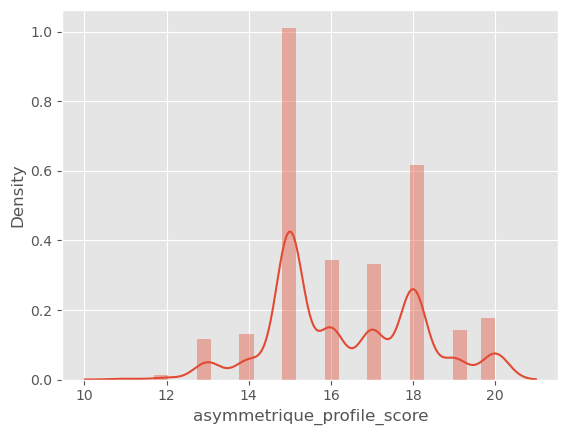

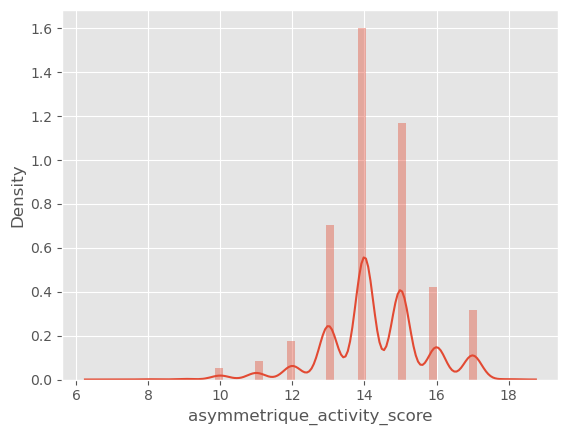

Both scores roughly follow standard distribution, therefore imputation can be done by median value.
Though instead of using scores, we shall use the categorical index columns derived from these scores.
Missing values will be filled by most frequently occuring category.


In [12]:
# Asymmetrique scores
for col in ['profile_score', 'activity_score']:
    sns.distplot(df['asymmetrique_'+col].dropna())
    plt.show()
    
print(f"Both scores roughly follow standard distribution, therefore imputation can be done by median value.\nThough instead of using scores, we shall use the categorical index columns derived from these scores.\nMissing values will be filled by most frequently occuring category.")

# Dropping Scores (Only Indexes will be used)
df.drop(['asymmetrique_profile_score', 'asymmetrique_activity_score'], axis=1, inplace=True)

# Removing initial numbers from category naming
df['asymmetrique_profile_index'] = df['asymmetrique_profile_index'].str[3:]
df['asymmetrique_activity_index'] = df['asymmetrique_activity_index'].str[3:]

# Replacing nan with most commonly occuring category
df['asymmetrique_activity_index'].fillna(df['asymmetrique_activity_index'].mode().values[0], inplace=True)
df['asymmetrique_profile_index'].fillna(df['asymmetrique_profile_index'].mode().values[0], inplace=True)

In [13]:
# Imputing for 'Country' and 'City'
print("\nWe'll first try understanding how cities are labelled for different country categories\n")

for country in df.country.dropna().unique():
    print(country.upper())
    print(df[df.country == country]['city'].value_counts())
    print()
    
print("It looks like customers outside India are wrongly marked as being from domestic cities.\n")

print("\nLets look at how countries are labeled w.r.t city categories\n")
for city in df.city.dropna().unique():
    print(city.upper())
    print(df[df.city == city]['country'].value_counts())
    print()
    
# We will make a new city label ('international') for countries labeled as 'others'
df.city[df.country == "others"] = df.city[df.country == "others"].replace(df.city[df.country == "others"].unique(), 'international')

# We'll also assume that rows with a domestic city label will have to have country label as 'india'.
df.country[(df.city != "international") & ~df.city.isna()] = 'india'

# We'll assume that rows with a country label 'india 'will have most frequently occuring city label.
df.city[(df.country == "india") & (df.city.isna())] = 'mumbai'


We'll first try understanding how cities are labelled for different country categories

INDIA
city
mumbai                         2918
thane_&_outskirts               651
other_cities                    564
other_cities_of_maharashtra     391
other_metro_cities              345
tier_ii_cities                   69
Name: count, dtype: int64

OTHERS
city
mumbai                         93
other_cities                   67
other_cities_of_maharashtra    23
thane_&_outskirts              21
other_metro_cities             20
tier_ii_cities                  3
Name: count, dtype: int64

It looks like customers outside India are wrongly marked as being from domestic cities.


Lets look at how countries are labeled w.r.t city categories

MUMBAI
country
india     2918
others      93
Name: count, dtype: int64

THANE_&_OUTSKIRTS
country
india     651
others     21
Name: count, dtype: int64

OTHER_METRO_CITIES
country
india     345
others     20
Name: count, dtype: int64

OTHER_CITIES
country
india 

In [14]:
print(f"There are {len(df[(df.city.isna()) & (df.country.isna())])} entries where both country and city are NA")
print("We'll mark these as 'unknown'")
df[['city', 'country']] = df[['city', 'country']].fillna('unknown', axis=1)

There are 2055 entries where both country and city are NA
We'll mark these as 'unknown'


In [15]:
# Few columns have less than 2% na values. We can afford to drop their respective rows altogehter. 
df.dropna(subset=['totalvisits', 'page_views_per', 'lead_source'], inplace=True)

# There are too many NA values with no logical way to impute in these columns so we will drop them entirely
df.drop(['specialization', 'tags', 'what_matters_most', 'what_is_your'] , axis=1, inplace=True)

round(df.isna().sum().sort_values(ascending=False), 2)

lead_origin                    0
lead_source                    0
a_free_copy                    0
asymmetrique_profile_index     0
asymmetrique_activity_index    0
city                           0
lead_quality                   0
through_recommendations        0
digital_advertisement          0
newspaper                      0
x_education_forums             0
newspaper_article              0
magazine                       0
search                         0
country                        0
page_views_per                 0
total_time_spent               0
totalvisits                    0
converted                      0
do_not_call                    0
do_not_email                   0
last_notable_activity          0
dtype: int64

In [17]:
# dummy encoding for the categorical variables
dummies = pd.get_dummies(df.select_dtypes(include=['object']), drop_first=True)

# getting the cleaned df
clean_df = df.drop(df.select_dtypes(include=['object']).columns, axis=1)
clean_df = pd.concat([clean_df, dummies], axis=1)

clean_df.head(2)

,converted,totalvisits,total_time_spent,page_views_per,lead_origin_landing_page_submission,lead_origin_lead_add_form,lead_origin_lead_import,lead_source_facebook,lead_source_google,lead_source_olark_chat,lead_source_organic_search,lead_source_others,lead_source_reference,lead_source_referral_sites,lead_source_welingak_website,do_not_email_yes,do_not_call_yes,country_others,country_unknown,search_yes,newspaper_article_yes,x_education_forums_yes,newspaper_yes,digital_advertisement_yes,through_recommendations_yes,...,city_other_cities_of_maharashtra,city_other_metro_cities,city_thane_&_outskirts,city_tier_ii_cities,city_unknown,asymmetrique_activity_index_low,asymmetrique_activity_index_medium,asymmetrique_profile_index_low,asymmetrique_profile_index_medium,a_free_copy_yes,last_notable_activity_email_bounced,last_notable_activity_email_link_clicked,last_notable_activity_email_marked_spam,last_notable_activity_email_opened,last_notable_activity_email_received,last_notable_activity_form_submitted_on_website,last_notable_activity_had_a_phone_conversation,last_notable_activity_modified,last_notable_activity_olark_chat_conversation,last_notable_activity_page_visited_on_website,last_notable_activity_resubscribed_to_emails,last_notable_activity_sms_sent,last_notable_activity_unreachable,last_notable_activity_unsubscribed,last_notable_activity_view_in_browser_link_clicked
0,0,0.0,0,0.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,0,5.0,674,2.5,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [19]:
print(f"{round(len(clean_df)/9239*100,2)}% data has been retained after data cleaning.")

98.21% data has been retained after data cleaning.


# EDA

### Correlations

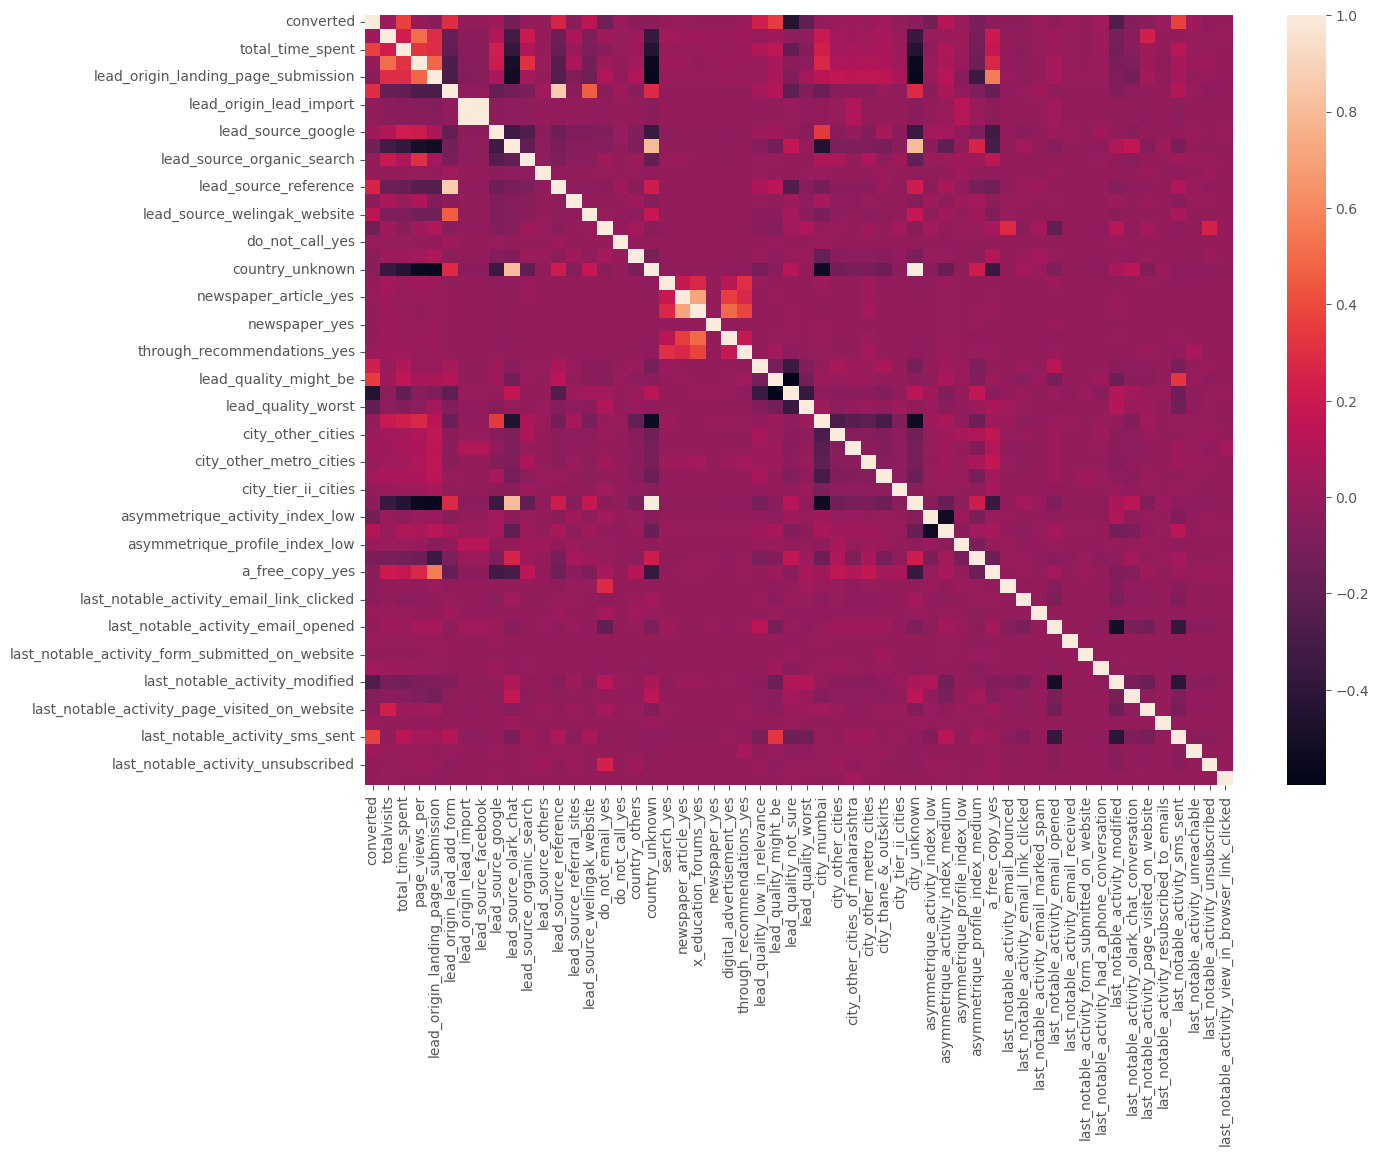

In [21]:
# visualizing correlation by heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(clean_df.corr())
plt.show()

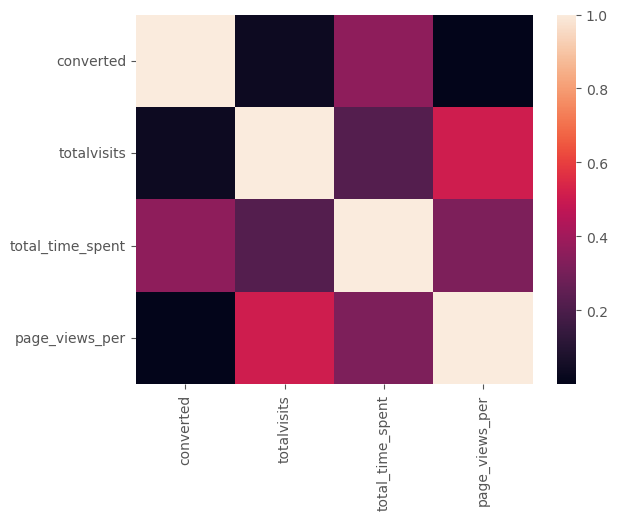

In [22]:
# heatmap of only continuous variables
sns.heatmap(clean_df[clean_df.columns[:4]].corr())
plt.show()

In [24]:
# columns pairs in order of highest absolute correlation
clean_df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates().head(12)

converted                            converted                              1.000000
lead_source_facebook                 lead_origin_lead_import                0.983684
lead_source_reference                lead_origin_lead_add_form              0.866191
lead_source_olark_chat               city_unknown                           0.803772
newspaper_article_yes                x_education_forums_yes                 0.707068
lead_quality_might_be                lead_quality_not_sure                  0.597667
country_unknown                      lead_origin_landing_page_submission    0.566471
lead_origin_landing_page_submission  a_free_copy_yes                        0.564863
page_views_per                       country_unknown                        0.556781
city_mumbai                          country_unknown                        0.536886
lead_origin_landing_page_submission  lead_source_olark_chat                 0.528424
asymmetrique_activity_index_low      asymmetrique_activity_index_

In [25]:
# Dropping variables with high multi-collinearity
clean_df.drop(['lead_source_facebook', 'lead_origin_lead_add_form', 'lead_source_olark_chat'], axis=1, inplace=True)

# Top 5 features correlated with target variable
clean_df.corr()['converted'].abs().sort_values(ascending=False).head(6)[1:]

lead_quality_not_sure             0.443920
last_notable_activity_sms_sent    0.360233
total_time_spent                  0.359261
lead_quality_might_be             0.349936
last_notable_activity_modified    0.263532
Name: converted, dtype: float64

### Univariate and Outlier Analysis¶


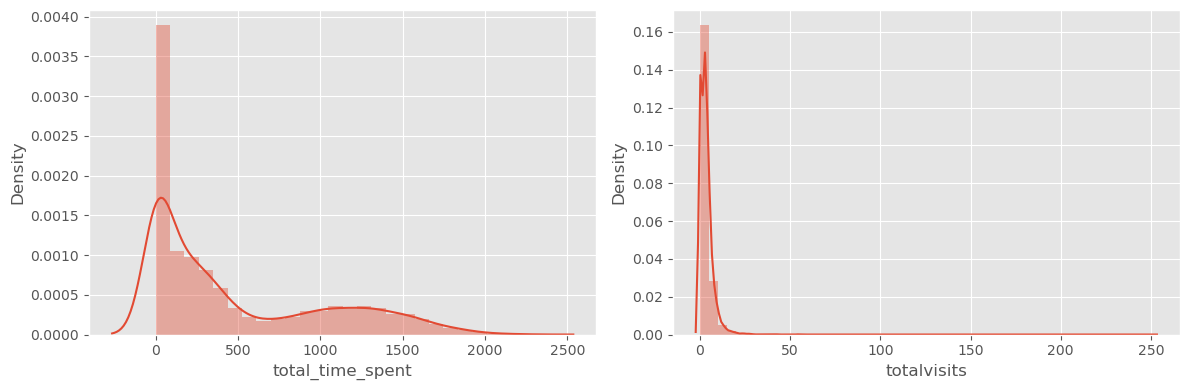

In [26]:


#Histogram
def plot_bars():
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    sns.distplot(clean_df['total_time_spent'])

    plt.subplot(122)
    sns.distplot(clean_df['totalvisits'])

    plt.tight_layout()
    plt.show()
    
plot_bars()



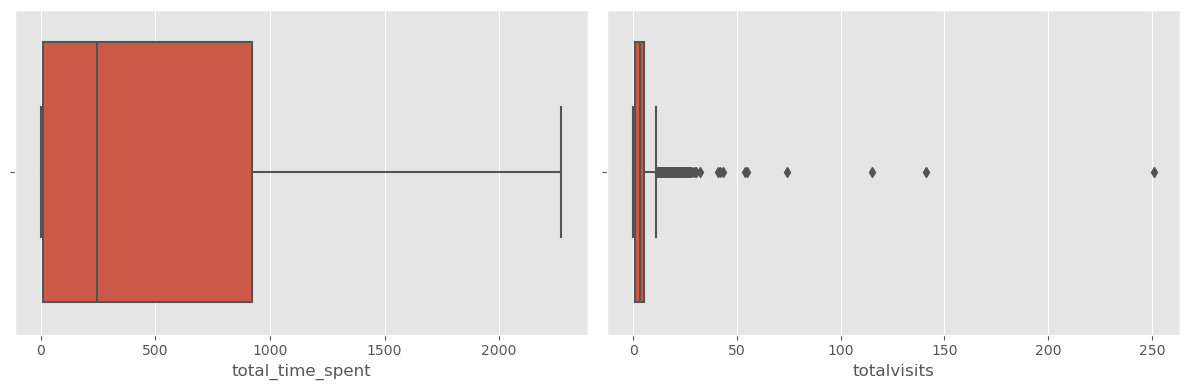

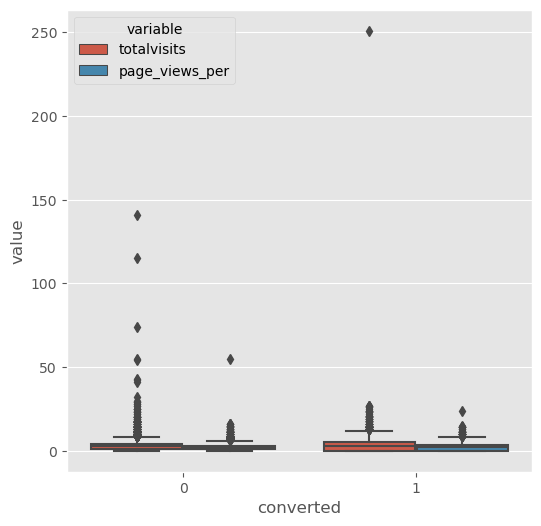

In [27]:
# Boxplots before outlier removal
num_df = clean_df[['converted', 'totalvisits',  'page_views_per', 'total_time_spent']]

def plot_boxes():
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    sns.boxplot(data=clean_df, x='total_time_spent')

    plt.subplot(122)
    sns.boxplot(data=clean_df, x='totalvisits')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    box_long = pd.melt(num_df.drop('total_time_spent', axis=1), id_vars='converted')
    sns.boxplot(x='converted', y='value', hue='variable', data=box_long)
    plt.show()
    
plot_boxes()

In [28]:
# Removing outliers
out_df = num_df.drop('converted', axis=1)
q = out_df.quantile(0.97)
out_df = out_df[out_df < q]
out_df = out_df.dropna()

clean_df = clean_df.loc[out_df.index].reset_index(drop=True)
num_df = num_df.loc[out_df.index].reset_index(drop=True)

print(f"{round(len(clean_df)/9239*100,2)}% data has been retained after outlier removal.")

88.78% data has been retained after outlier removal.


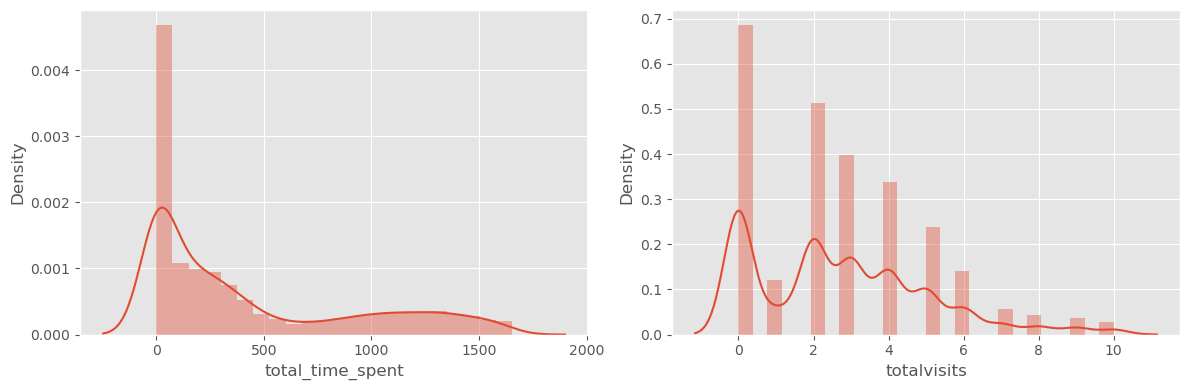

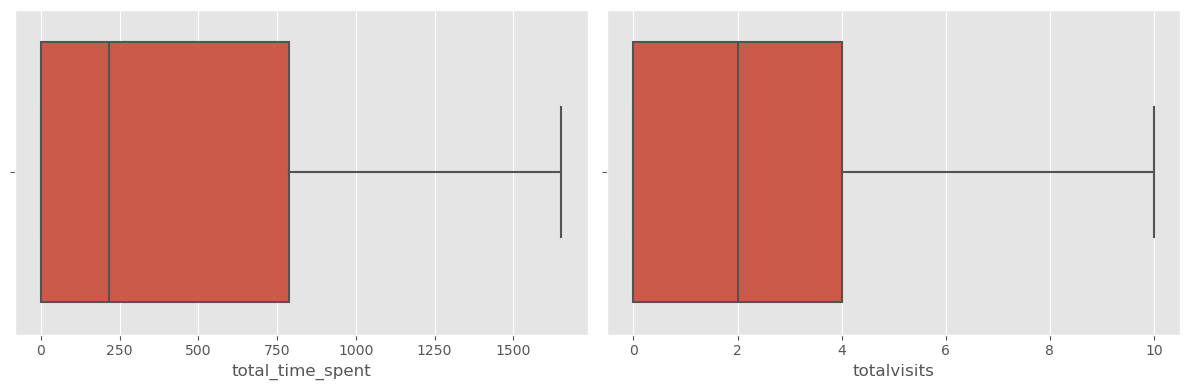

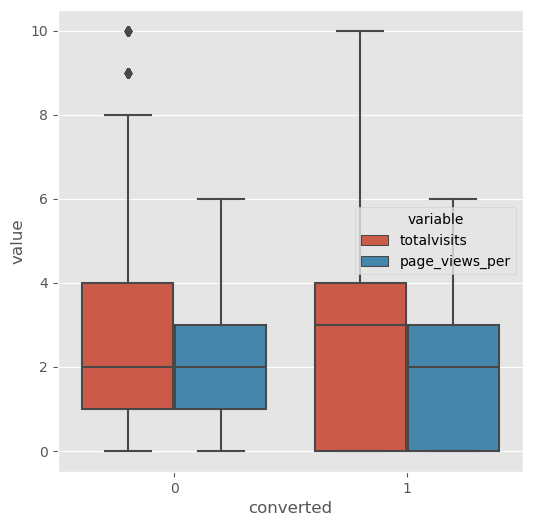

In [29]:
# After Outlier removal
plot_bars()
plot_boxes()

###  Bivariate Analysis¶


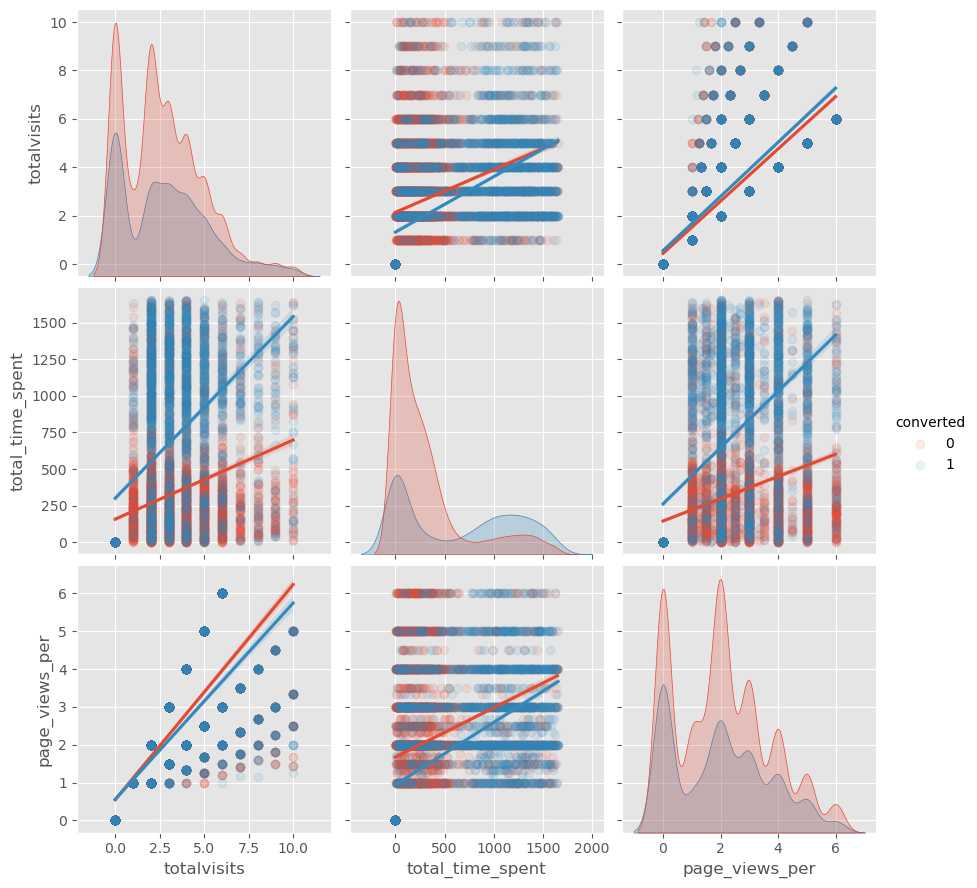

In [31]:
sns.pairplot(data=clean_df, vars=clean_df.columns[1:4], hue='converted', kind='reg', height=3,
             plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.show()

# Building the Predictive Mode

### Splitting into Train and Test

In [33]:
# Performing split to prevent imbalance and bias

In [34]:
# Stratified Train Test Split
X = clean_df.drop('converted', axis=1)
y = clean_df['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

## 
Scaling (Normalisation)### 

We will perform Min Max scaling on the Continuous numerical variabes


In [35]:
# Min Max Scaling
scaler = MinMaxScaler()
cols = X_train.columns
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[cols[:3]]), columns=cols[:3])
scaled_X_train = pd.concat([scaled_X_train, X_train.drop(cols[:3], axis=1).reset_index(drop=True)], axis=1)

scaled_X_test = pd.DataFrame(scaler.transform(X_test[cols[:3]]), columns=cols[:3])
scaled_X_test = pd.concat([scaled_X_test, X_test.drop(cols[:3], axis=1).reset_index(drop=True)], axis=1)

## PCA

In [36]:
# Generating principal components of continuous variables
pca = PCA(random_state=42)
decomp_df = pca.fit_transform(scaled_X_train[cols[:3]])
pc_frame = pd.DataFrame({'Features': cols[:3], 'PC1': pca.components_[0], 'PC2': pca.components_[1], 'PC3': pca.components_[2]})
pc_frame

,Features,PC1,PC2,PC3
0,totalvisits,0.512978,-0.369512,0.774800
1,total_time_spent,0.597301,0.801911,-0.013018
2,page_views_per,0.616510,-0.469467,-0.632073


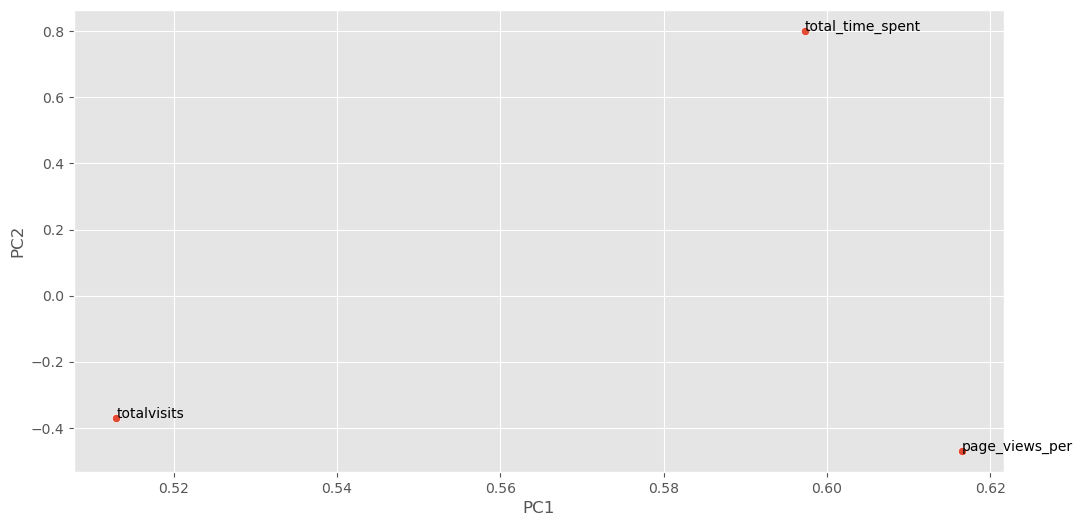

In [37]:
# Plotting 2 principal compnonents for the numeric variables
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pc_frame, x='PC1', y='PC2')
for i, text in enumerate(pc_frame.Features):
    plt.annotate(text, (pc_frame.PC1[i], pc_frame.PC2[i]))

plt.show()

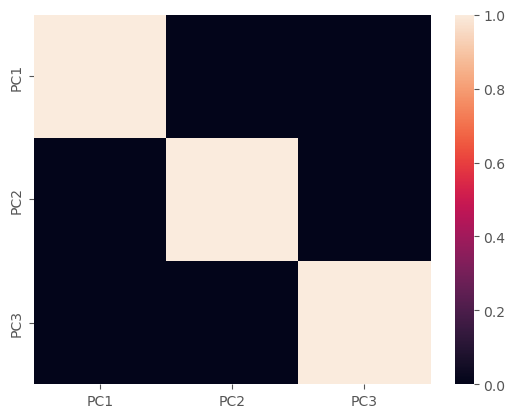

In [38]:
# No correlation exists between the PCs
decomp_df = pd.DataFrame(decomp_df, columns=['PC1', 'PC2', 'PC3'])
sns.heatmap(decomp_df.corr())
plt.show()

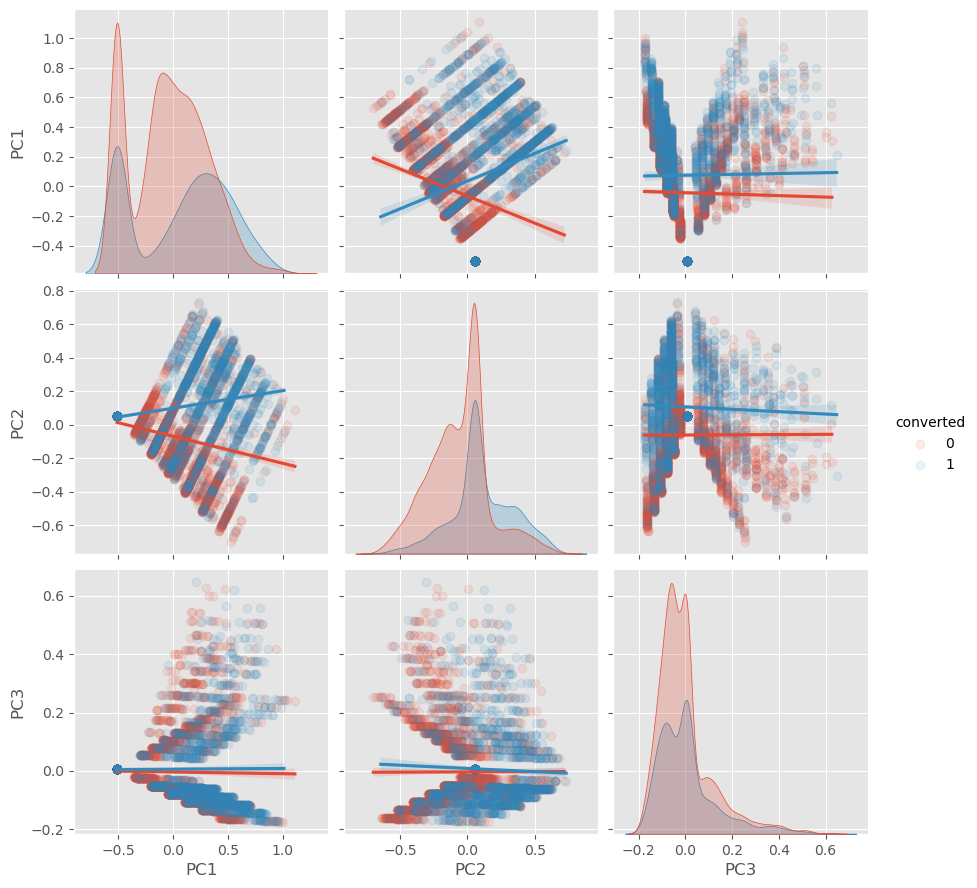

In [39]:
# Pairplot Of all 3 PCs
sns.pairplot(data=pd.concat([decomp_df, y_train.reset_index(drop=True)], axis=1),
             vars=['PC1', 'PC2', 'PC3'], hue='converted', kind='reg', height=3,
             plot_kws={'scatter_kws': {'alpha': 0.1}})

plt.show()

In [40]:
# We'll use all 3 principal components
scaled_X_train = pd.concat([scaled_X_train.reset_index(drop=True), decomp_df], axis=1)

# applying to test set
decomp_test = pca.transform(scaled_X_test[cols[:3]])
decomp_test = pd.DataFrame(decomp_test, columns=['PC1', 'PC2', 'PC3'])
scaled_X_test = pd.concat([scaled_X_test.reset_index(drop=True), decomp_test], axis=1)

### Recurssive Feature Elimination and Cross Validation

In [43]:
def optimal_features(min, max):
    
    opt = list()
    for features in range(min, max):
        log_reg = LogisticRegression(C=2, random_state=42)
        rfe = RFE(estimator=log_reg, n_features_to_select=features)
        rfe.fit(scaled_X_train, y_train)
        cols = scaled_X_train.columns[rfe.support_]

        # Cross Validation
        scores = cross_validate(log_reg, scaled_X_train[cols], y_train, return_train_score=True, cv=5, scoring=['accuracy'])
        opt.append((features, scores['test_accuracy'].mean()))
        
    opt = np.array(opt) 
    return opt, opt[opt[:, 1].argmax()]
    

feat_array, opt_features = optimal_features(10, 50)

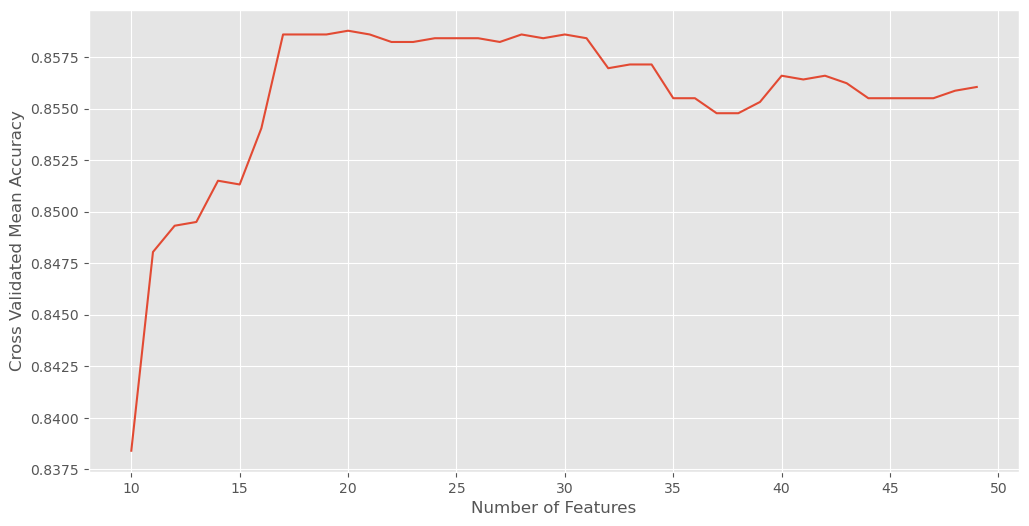

Optimal number of features to use is 20.0 which gives 0.8587807097361237 accuracy.


In [44]:
plt.figure(figsize=(12, 6))
plt.plot(feat_array[:, 0], feat_array[:, 1])
plt.xlabel("Number of Features")
plt.ylabel("Cross Validated Mean Accuracy")
plt.show()

print(f"Optimal number of features to use is {opt_features[0]} which gives {opt_features[1]} accuracy.")

In [52]:
# RFE
log_reg = LogisticRegression(C=2, random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=int(opt_features[0]))
rfe.fit(scaled_X_train, y_train)
cols = scaled_X_train.columns[rfe.support_]
print(f"The columns we'll be using are:\n\n{cols}")

The columns we'll be using are:

Index(['total_time_spent', 'lead_source_others', 'lead_source_reference',
       'lead_source_welingak_website', 'do_not_email_yes', 'do_not_call_yes',
       'search_yes', 'lead_quality_might_be', 'lead_quality_not_sure',
       'lead_quality_worst', 'city_unknown', 'asymmetrique_activity_index_low',
       'last_notable_activity_had_a_phone_conversation',
       'last_notable_activity_olark_chat_conversation',
       'last_notable_activity_resubscribed_to_emails',
       'last_notable_activity_sms_sent', 'last_notable_activity_unreachable',
       'PC1', 'PC2', 'PC3'],
      dtype='object')


# VIF

In [1]:
def get_vif(scaled_X_train, cols):
   
    X = scaled_X_train[cols].apply(pd.to_numeric, errors='coerce')  # Convert to numeric and coerce errors to NaN
    X = X.dropna()  # Drop rows with NaN values (you can alternatively fill NaNs)
    
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    
    # Sort by VIF
    vif = vif.sort_values(by="VIF", ascending=False)
    
    return vif



In [55]:
X = X.fillna(X.mean())

In [ ]:
cols = cols.drop('total_time_spent')
get_vif().head()

In [61]:
### Assesing the model with statsmodel¶


In [63]:
## Fitting the model

In [64]:
# Cross Validation
scores = cross_validate(log_reg, scaled_X_train[cols], y_train, return_train_score=True, cv=5, scoring=['accuracy'])
print(f"Cross validated mean accuracy: {round(scores['test_accuracy'].mean(), 3)}")

log_reg.fit(scaled_X_train[cols], y_train)
pred = log_reg.predict(scaled_X_train[cols])
prob_est = log_reg.predict_proba(scaled_X_train[cols])

Cross validated mean accuracy: 0.859


Sensitivity (Recall): 0.773247140726007
Specificity: 0.9090126291618829
Precision: 0.8306623931623932
F-Score: 0.8009271182075715


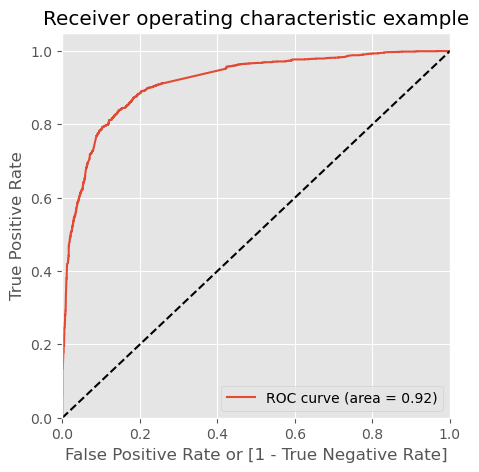

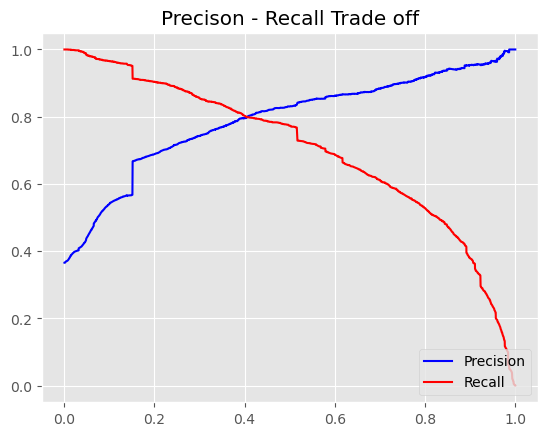

In [65]:
def draw_roc(actual_values, probability_estimates):
    fpr, tpr, thresholds = roc_curve(actual_values, probability_estimates, drop_intermediate=False)
    auc_score = roc_auc_score(actual_values, probability_estimates)
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {round(auc_score, 2)})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def draw_prec_recall(actual_values, probability_estimates):
    
    p, r, thresholds = precision_recall_curve(actual_values, probability_estimates)
    plt.plot(thresholds, p[:-1], "b-", label="Precision")
    plt.plot(thresholds, r[:-1], "r-", label="Recall")
    plt.title("Precison - Recall Trade off")
    plt.legend(loc="lower right")
    plt.show()

def get_metrics(y, pred, prob_est):
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    f = f1_score(y, pred)

    # Sensitivity, Specificity
    print(f"Sensitivity (Recall): {recall}\nSpecificity: {tn/(tn+fp)}\nPrecision: {precision}\nF-Score: {f}")

    # Reciever Operating Characteristic Curve
    draw_roc(y, prob_est[:, 1])

    # Precision Recall Curve
    draw_prec_recall(y, prob_est[:, 1])
    
get_metrics(y_train, pred, prob_est)

### Finding Optimal Cut-Off

In [66]:
# Making y_train_pred_final
y_train_pred_final = pd.DataFrame({'Converted':y_train, 'probability': prob_est[:, 1]})
numbers = np.round(np.linspace(0,1,40,endpoint=False), 2)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.probability.map(lambda x: 1 if x > i else 0)

# Making cutoffs
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
num = np.round(np.linspace(0,1,40,endpoint=False), 2)
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

cutoff_df['var'] = np.var([cutoff_df.accuracy, cutoff_df.sensi, cutoff_df.speci], axis=0)

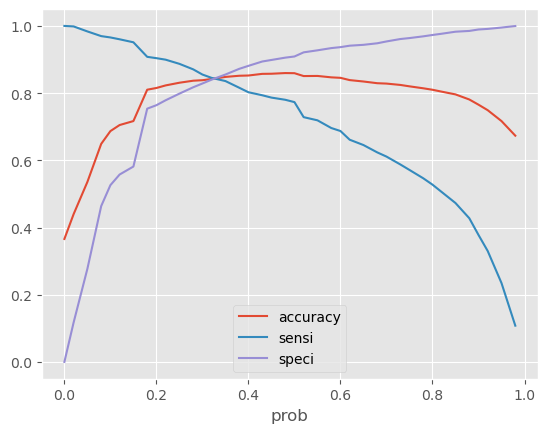

Optimum cut-off value is: 0.32


In [67]:
# plotting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

cutoff_value = cutoff_df.sort_values('var').head(1)['prob'].values[0]
print(f"Optimum cut-off value is: {cutoff_value}")

Accuracy: 0.8420382165605096
Sensitivity (Recall): 0.8453505718547986
Specificity: 0.8401262916188289
Precision: 0.7532122286220647
F-Score: 0.7966260543580131


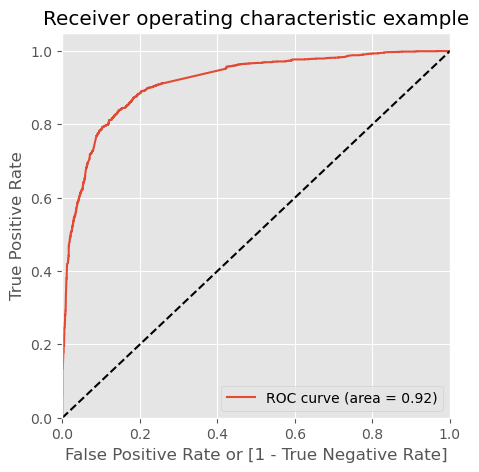

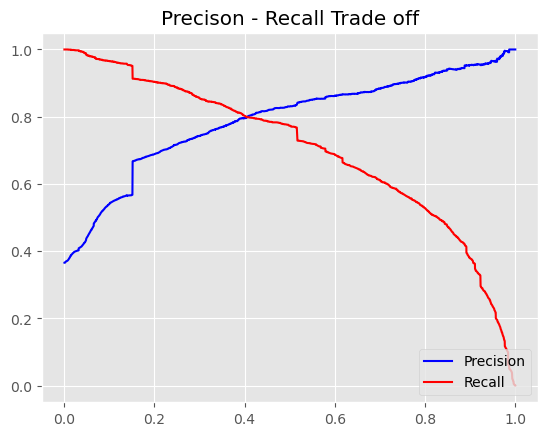

In [68]:
# new predicted values based on cut-off
pred = (log_reg.predict_proba(scaled_X_train[cols])[:, 1] >= cutoff_value).astype(int)
print(f"Accuracy: {accuracy_score(y_train, pred)}")
get_metrics(y_train, pred, prob_est)

### Measuring Performance on Test Set

accuracy: 0.8511267085334319
Sensitivity (Recall): 0.8505050505050505
Specificity: 0.8514851485148515
Precision: 0.7675478577939836
F-Score: 0.8068998562529947


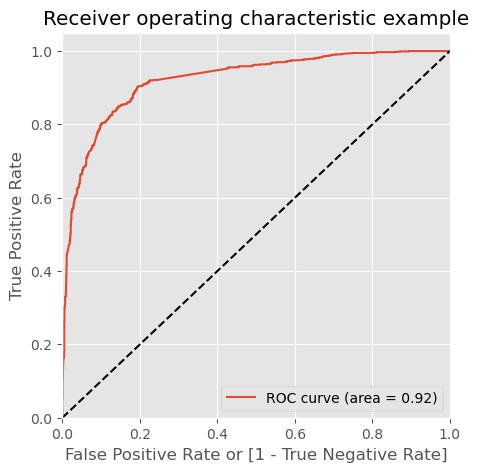

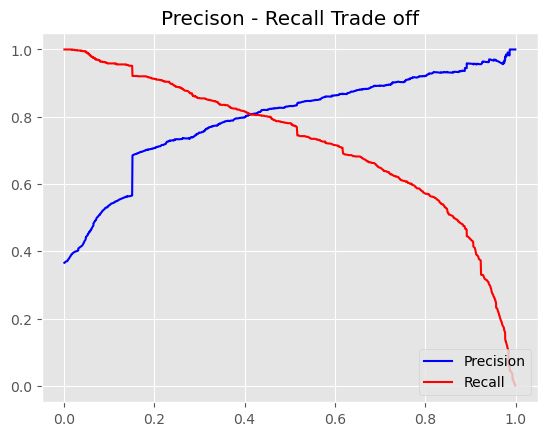

In [69]:
# Scoring against Test Set
log_reg.fit(scaled_X_train[cols], y_train)
pred = (log_reg.predict_proba(scaled_X_test[cols])[:, 1] >= cutoff_value).astype(int)
prob_est = log_reg.predict_proba(scaled_X_test[cols])
print(f"accuracy: {accuracy_score(y_test, pred)}")
get_metrics(y_test, pred, prob_est)

# Lead Scoring

## We will perform lead-scoring on the test set.


In [71]:
scores = pd.DataFrame({'lead_score':(prob_est[:, 1]*100).astype('int'), 'predicted_outcome': pred, 'actual_outcome': y_test}).reset_index(drop=True)
scores.head()

,lead_score,predicted_outcome,actual_outcome
0,15,0,0
1,93,1,1
2,0,0,0
3,77,1,1
4,92,1,1
